# LSTM Stock Predictor Using Fear and Greed Index

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin fear and greed index values to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [29]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [30]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [31]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [32]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [33]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [34]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [35]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [36]:
# Predict Closing Prices using a 10 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)
print(f"X sample values: \n{X[:5]} \n")
print(f"y sample values: \n{y[:5]}")

X sample values: 
[[30 15 40 24 11  8 36 30 44 54]
 [15 40 24 11  8 36 30 44 54 31]
 [40 24 11  8 36 30 44 54 31 42]
 [24 11  8 36 30 44 54 31 42 35]
 [11  8 36 30 44 54 31 42 35 55]] 

y sample values: 
[[ 8084.609863]
 [ 8911.269531]
 [ 8544.69043 ]
 [ 9485.639648]
 [10033.75    ]]


In [37]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [38]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
X_train_scaled = MinMaxScaler()
X_test_scaled = MinMaxScaler()
y_train_scaled = MinMaxScaler()
y_test_scaled = MinMaxScaler()

# Fitting the training data

X_train_scaled.fit(X_train)
y_train_scaled.fit(y_train)
X_train = X_train_scaled.transform(X_train)
y_train = y_train_scaled.transform(y_train)

# Fitting the testing data

X_test_scaled.fit(X_test)
y_test_scaled.fit(y_test)
X_test = X_test_scaled.transform(X_test)
y_test = y_test_scaled.transform(y_test)

In [39]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(f"X_train sample values: \n{X_train[:5]} \n")
print(f"X_test sample values: \n{X_test[:5]}")

X_train sample values: 
[[[0.33333333]
  [0.10606061]
  [0.48484848]
  [0.24242424]
  [0.04545455]
  [0.        ]
  [0.41538462]
  [0.32307692]
  [0.53846154]
  [0.69230769]]

 [[0.10606061]
  [0.48484848]
  [0.24242424]
  [0.04545455]
  [0.        ]
  [0.42424242]
  [0.32307692]
  [0.53846154]
  [0.69230769]
  [0.33846154]]

 [[0.48484848]
  [0.24242424]
  [0.04545455]
  [0.        ]
  [0.42424242]
  [0.33333333]
  [0.53846154]
  [0.69230769]
  [0.33846154]
  [0.50769231]]

 [[0.24242424]
  [0.04545455]
  [0.        ]
  [0.42424242]
  [0.33333333]
  [0.54545455]
  [0.69230769]
  [0.33846154]
  [0.50769231]
  [0.4       ]]

 [[0.04545455]
  [0.        ]
  [0.42424242]
  [0.33333333]
  [0.54545455]
  [0.6969697 ]
  [0.33846154]
  [0.50769231]
  [0.4       ]
  [0.70769231]]] 

X_test sample values: 
[[[0.30379747]
  [0.37974684]
  [0.27848101]
  [0.40506329]
  [0.40506329]
  [0.34177215]
  [0.34177215]
  [0.3164557 ]
  [0.27848101]
  [0.59493671]]

 [[0.37974684]
  [0.27848101]
  [0.4050

---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [50]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 30
dropout_fraction = 0.2


# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, ))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [53]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [54]:
# Summarize the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 10, 40)            6720      
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 40)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 10, 40)            12960     
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 40)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 40)                12960     
_________________________________________________________________
dropout_11 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [56]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
371/371 [==============================] - 1s 4ms/step - loss: 0.0241
Epoch 2/10
371/371 [==============================] - 1s 3ms/step - loss: 0.0290
Epoch 3/10
371/371 [==============================] - 1s 4ms/step - loss: 0.0349
Epoch 4/10
371/371 [==============================] - 1s 4ms/step - loss: 0.0337
Epoch 5/10
371/371 [==============================] - 1s 4ms/step - loss: 0.0344
Epoch 6/10
371/371 [==============================] - 1s 3ms/step - loss: 0.0323
Epoch 7/10
371/371 [==============================] - 1s 3ms/step - loss: 0.0329
Epoch 8/10
371/371 [==============================] - 1s 3ms/step - loss: 0.0330
Epoch 9/10
371/371 [==============================] - 1s 3ms/step - loss: 0.0347
Epoch 10/10
371/371 [==============================] - 1s 3ms/step - loss: 0.0353


---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [45]:
# Evaluate the model
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.1911


0.1911109983921051

In [46]:
# Make some predictions
predicted = model.predict(X_test)

In [47]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaled.inverse_transform(predicted)
real_prices = y_test_scaled.inverse_transform(y_test.reshape(-1, 1))

In [48]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,4106.430176
2019-02-21,3974.050049,4104.130859
2019-02-22,3937.040039,4105.453125
2019-02-23,3983.530029,4101.009766
2019-02-24,4149.089844,4102.781250


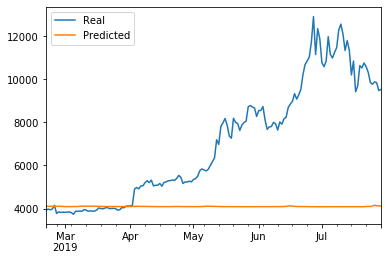

In [49]:
# Plot the real vs predicted values as a line chart
stocks.plot()

In [28]:
# Experimenting with the model architecture and parameters

For this experiment we will increase the number of units from 30 to 40 and increase the batch size from 1 to 2 and see what is the impact on the models

In [89]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 40
dropout_fraction = 0.2


# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, ))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [90]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [91]:
# Summarize the model
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 10, 40)            6720      
_________________________________________________________________
dropout_27 (Dropout)         (None, 10, 40)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 10, 40)            12960     
_________________________________________________________________
dropout_28 (Dropout)         (None, 10, 40)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 40)                12960     
_________________________________________________________________
dropout_29 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)               

In [92]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=2, verbose=1)

Epoch 1/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0383
Epoch 2/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0415
Epoch 3/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0411
Epoch 4/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0381
Epoch 5/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0360
Epoch 6/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0406
Epoch 7/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0457
Epoch 8/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0569
Epoch 9/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0578
Epoch 10/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0571


In [93]:
# Evaluate the model
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 4ms/step - loss: 0.1043


0.10427991300821304

In [94]:
# Make some predictions
predicted = model.predict(X_test)

In [95]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaled.inverse_transform(predicted)
real_prices = y_test_scaled.inverse_transform(y_test.reshape(-1, 1))

In [96]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,5513.713867
2019-02-21,3974.050049,5562.924316
2019-02-22,3937.040039,5611.469727
2019-02-23,3983.530029,5661.325195
2019-02-24,4149.089844,5697.121582


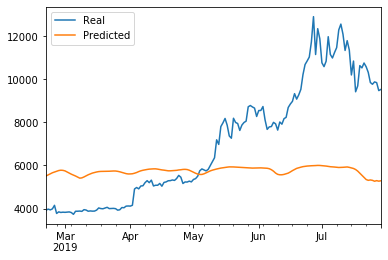

In [98]:
# Plot the real vs predicted values as a line chart
stocks.plot()

In [63]:
# Experimenting with the model architecture and parameters

Now we will experiment using 20 number of units instead of 40 and stil 2 batch sizes to see what will the impact be on the models

In [78]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 20
dropout_fraction = 0.2


# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, ))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [67]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [68]:
# Summarize the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 10, 20)            1760      
_________________________________________________________________
dropout_15 (Dropout)         (None, 10, 20)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 10, 20)            3280      
_________________________________________________________________
dropout_16 (Dropout)         (None, 10, 20)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dropout_17 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [82]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=2, verbose=1)

Epoch 1/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0644
Epoch 2/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0520
Epoch 3/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0540
Epoch 4/10
186/186 [==============================] - 1s 6ms/step - loss: 0.0548
Epoch 5/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0588
Epoch 6/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0601
Epoch 7/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0586
Epoch 8/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0559
Epoch 9/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0559
Epoch 10/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0566


In [83]:
# Evaluate the model
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 5ms/step - loss: 0.1006


0.1006297618150711

In [84]:
# Make some predictions
predicted = model.predict(X_test)

In [85]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaled.inverse_transform(predicted)
real_prices = y_test_scaled.inverse_transform(y_test.reshape(-1, 1))

In [86]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,5560.572266
2019-02-21,3974.050049,5608.952637
2019-02-22,3937.040039,5661.994629
2019-02-23,3983.530029,5714.959961
2019-02-24,4149.089844,5757.246582


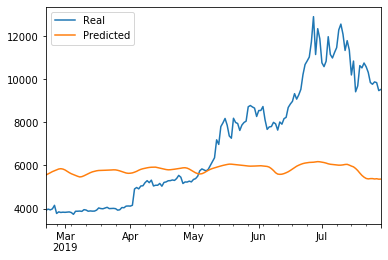

In [87]:
# Plot the real vs predicted values as a line chart
stocks.plot()

Now, let's experiment with 25 units and 15 epochs with 1 batch size

In [99]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 25
dropout_fraction = 0.2


# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, ))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [100]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [101]:
# Summarize the model
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 10, 25)            2700      
_________________________________________________________________
dropout_30 (Dropout)         (None, 10, 25)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
dropout_31 (Dropout)         (None, 10, 25)            0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 25)                5100      
_________________________________________________________________
dropout_32 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)               

In [102]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=15, shuffle=False, batch_size=1, verbose=1)

Epoch 1/15
371/371 [==============================] - 1s 3ms/step - loss: 0.0370
Epoch 2/15
371/371 [==============================] - 1s 3ms/step - loss: 0.0341
Epoch 3/15
371/371 [==============================] - 1s 3ms/step - loss: 0.0377
Epoch 4/15
371/371 [==============================] - 1s 3ms/step - loss: 0.0377
Epoch 5/15
371/371 [==============================] - 1s 3ms/step - loss: 0.0367
Epoch 6/15
371/371 [==============================] - 1s 3ms/step - loss: 0.0389
Epoch 7/15
371/371 [==============================] - 1s 3ms/step - loss: 0.0405
Epoch 8/15
371/371 [==============================] - 1s 3ms/step - loss: 0.0387
Epoch 9/15
371/371 [==============================] - 1s 3ms/step - loss: 0.0399
Epoch 10/15
371/371 [==============================] - 1s 3ms/step - loss: 0.0497
Epoch 11/15
371/371 [==============================] - 1s 3ms/step - loss: 0.0576
Epoch 12/15
371/371 [==============================] - 1s 3ms/step - loss: 0.0598
Epoch 13/15
371/371 [====

In [103]:
# Evaluate the model
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 3ms/step - loss: 0.1071


0.10714753717184067

In [104]:
# Make some predictions
predicted = model.predict(X_test)

In [107]:
# Recover the original prices instead of the scaled prices
predicted_prices = y_test_scaled.inverse_transform(predicted)
real_prices = y_test_scaled.inverse_transform(y_test).reshape(-1, 1)

In [109]:
# Create a DataFrame of Real and Predicted Values

stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,5741.800293
2019-02-21,3974.050049,5744.178223
2019-02-22,3937.040039,5746.212891
2019-02-23,3983.530029,5748.289062
2019-02-24,4149.089844,5750.229980


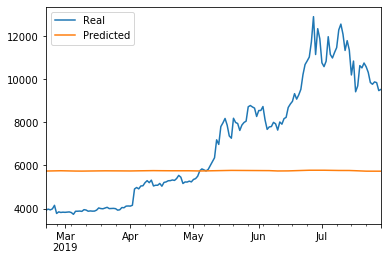

In [111]:
# Plot the real vs predicted values as a line chart
stocks.plot()